![image](../../images/618_tutorials_banner_logos.png) 

# TO DO
- [ ] desription of the data (resolutions, sampling etc)
- [x] Download GLiht HSI and lidar
- [x] visualize both dataset
- [ ] extract footprint info
- [x] calculate metrics (scene/band stats, NDVI)
- [ ] analysis
    - [ ] descriptions (what can be calculated, dimension reduction, classification, veg health/surface indices,
    - [ ] visualize pixel-wise relationships (e.g., canopy height ~ NDVI)
    - [ ] 
- [ ] rm data


Optionals:
- [ ] add demo POIs (25m circles)
    - [ ] extract metrics and relate to
- [ ] add Landsat or Sentinel data to relate to medium-res EO data


# WIP - GLiHT sandbox 
---
**Summary**
This tutorial will guide you through using lidar data from the GLiHT (Goddard LIdar, Hyperspectral, and Thermal) airborne imaging dataset including common geospatial considerations, how to co-locate the dataset with Earth observation imagery, and how to analyze the datasets.


**Learning Objectives**
1. access and download GLiHT lidar and hyperspectral data,
2. understand the dataset features and structure,
3. explore the datasets through analyses.

**Requirements**
- TBD

#### Contact Info**

**Author:** Colin Quinn (Github: [CQuinn8](https://github.com/CQuinn8))  
**Last Update:** 2025-11-10 (Created: 2025-11-10)  
**Website:** <https://github.com/GSFC-618/618-tutorials>


## Environment Setup 
**Environment:** conda env create -f global-airborne-core-20251107.yaml

In [1]:
# general env libs
import os
import sys
from io import BytesIO
import tarfile
import gzip
import shutil

# libs that aid downloading https data
import requests
from pathlib import Path
from tqdm import tqdm

# geospatial libraries
import rasterio
import rasterio.plot
import h5py

In [2]:
# Provide any custom user arguments such as whether to save outputs (csvs, plots, processed datasets)
save_outputs=True
output_directory="~"

## Authentication 
None needed. As of writing this notebook, datasets are downloaded from the open-access [GLiHT archive](https://glihtdata.gsfc.nasa.gov).

## Import data


### Derived lidar products
Canopy height model (CHM)
Lidar-derived maximum canopy height (m AGL) and canopy rugosity (i.e., standard deviation of heights within an area equivalent to a 1/24 ac USFS-FIA subplot). Available as Google Earth overlay (KML) and raster data product (GeoTIFF) at a nominal 1 m spatial resolution.
- https://glihtdata.gsfc.nasa.gov/files/G-LiHT/Rocky_Point_Jun2016/lidar/geotiff/Rocky_Point_Jun2016_CHM.tif.gz

Digital Terrain Model (DTM)
Lidar-derived bare earth elevation (m, EGM96 geoid), aspect and slope. Available as Google Earth overlay (KML) and raster data product (GeoTIFF) at a nominal 1 m spatial resolution.
- https://glihtdata.gsfc.nasa.gov/files/G-LiHT/Rocky_Point_Jun2016/lidar/geotiff/Rocky_Point_Jun2016_DTM.tif.gz

[Metrics](https://glihtdata.gsfc.nasa.gov/metrics_readme.pdf)
Common lidar height and density metrics and return statistics (e.g., mean pulse density, returns per pulse). Available as raster data product (GeoTIFF) at a nominal 13 m spatial resolution (area equivalent to a 1/24 ac USFS-FIA subplot). A detailed list of available metrics and related publications is available in the Metrics Readme.
- https://glihtdata.gsfc.nasa.gov/files/G-LiHT/Rocky_Point_Jun2016/lidar/geotiff/metrics/ 

### Hyperspectral imagery (HSI; mosaicked reflectances)
VNIR Image spectrometer data (420 to 920 nm, 4.5 nm sampling interval) and data products are available as orthorectified raster files (ENVI) at a nominal 1 m spatial resolution. At-sensor reflectance data is computed as the ratio between observed upwelling radiance and downwelling hemispheric irradiance, and corrected for differences in cross-track illumination and BRDF using an empirically derived multiplier. At a nominal flying height of 335 m AGL, the at-sensor reflectance is a close approximation of surface reflectance. Available for individual swaths, and mosaicked for mapped areas using observations closest to nadir.
- https://glihtdata.gsfc.nasa.gov/files/G-LiHT/Rocky_Point_Jun2016/hyperspec/Rocky_Point_Jun2016_mosaicked_refl_VIs.tar.gz

### metadata
- https://glihtdata.gsfc.nasa.gov/files/G-LiHT/Rocky_Point_Jun2016/lidar/geotiff/metrics/ https://glihtdata.gsfc.nasa.gov/files/G-LiHT/Rocky_Point_Jun2016/metadata/Rocky_Point_Jun2016_metadata.pdf



### las files (not used here)
Individual lidar return data, including 3D coordinates; classified ground returns ("Classification" field); AGL heights ("Point Source ID Text" field, using z scale factor and offsets); and lidar apparent reflectance ("Intensity" field; see accompanying metadata for 2 byte dB range). Available in ASPRS LAS 1.1 format.
- https://glihtdata.gsfc.nasa.gov/files/G-LiHT/Rocky_Point_Jun2016/lidar/las/Rocky_Point_Jun2016_c0r0.las.gz 
- https://glihtdata.gsfc.nasa.gov/files/G-LiHT/Rocky_Point_Jun2016/lidar/las/Rocky_Point_Jun2016_c1r0.las.gz 
- https://glihtdata.gsfc.nasa.gov/files/G-LiHT/Rocky_Point_Jun2016/lidar/las/Rocky_Point_Jun2016_c0r1.las.gz 
- https://glihtdata.gsfc.nasa.gov/files/G-LiHT/Rocky_Point_Jun2016/lidar/las/Rocky_Point_Jun2016_c1r1.las.gz



In [3]:
# Create a directory to store GLiHT data
download_dir = Path("./data/")
download_dir.mkdir(exist_ok = True, parents=True)

In [89]:
# urls for the CHM, DTM, HSI, and metadata pdf
urls = [
    'https://glihtdata.gsfc.nasa.gov/files/G-LiHT/Rocky_Point_Jun2016/lidar/geotiff/Rocky_Point_Jun2016_CHM.tif.gz',
    'https://glihtdata.gsfc.nasa.gov/files/G-LiHT/Rocky_Point_Jun2016/lidar/geotiff/Rocky_Point_Jun2016_DTM.tif.gz',
    'https://glihtdata.gsfc.nasa.gov/files/G-LiHT/Rocky_Point_Jun2016/hyperspec/Rocky_Point_Jun2016_mosaicked_refl_VIs.tar.gz',
    'https://glihtdata.gsfc.nasa.gov/files/G-LiHT/Rocky_Point_Jun2016/metadata/Rocky_Point_Jun2016_metadata.pdf',
    #'https://glihtdata.gsfc.nasa.gov/files/G-LiHT/Brookhaven_Jun2016/hyperspec/Brookhaven_Jun2016_mosaicked_refl_VIs.tar.gz'
]

In [90]:
for url in urls:
    out_file = Path(download_dir / Path(url).name)
    if out_file.exists():
        print(f"File already downloaded/present: {out_file}")
        print("---"*20)
        continue
    else:        
        try:
            with requests.get(url, stream = True, timeout=60) as r:
                r.raise_for_status()
                total = int(r.headers.get('content-length', 0))
                with open(out_file, "wb") as input_file, tqdm(
                    total=total, 
                    unit='B', 
                    unit_divisor=1024,
                    unit_scale=True, 
                    desc=out_file.name
                ) as bar:
                    for chunk in r.iter_content(chunk_size=10*1024*1024): # working on EFS, reduce number of i/o chunks with 10MB chunks
                        input_file.write(chunk)
                        bar.update(len(chunk))
                    print("Download complete")
        except requests.exceptions.RequestException as e:
                    print(f"FAILED download: {url} : {e}")
        print("---"*20)

File already downloaded/present: data/Rocky_Point_Jun2016_CHM.tif.gz
------------------------------------------------------------
File already downloaded/present: data/Rocky_Point_Jun2016_DTM.tif.gz
------------------------------------------------------------
File already downloaded/present: data/Rocky_Point_Jun2016_mosaicked_refl_VIs.tar.gz
------------------------------------------------------------
File already downloaded/present: data/Rocky_Point_Jun2016_metadata.pdf
------------------------------------------------------------


Brookhaven_Jun2016_mosaicked_refl_VIs.tar.gz: 100%|██████████| 3.53G/3.53G [09:45<00:00, 6.47MB/s]

Download complete
------------------------------------------------------------


In [ ]:
#add in check that archives have been extracted first
# currently this does not uncompress data correctly (gzip -d <file>)
gliht_archive_files = Path(download_dir).glob("*.gz")
                           
for archive_f in gliht_archive_files:
    print(archive_f)
    if tarfile.is_tarfile(archive_f):
        with tarfile.open(archive_f, 'r:gz') as tar:
            tar.extractall(path=download_dir)
    elif archive_f.suffix == ".gz":
        output_file = archive_f.with_suffix("")  
        with gzip.open(archive_f, 'rb') as f_in:
            with open(output_file, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)

data/Brookhaven_Jun2016_mosaicked_refl_VIs.tar.gz


/tmp/ipykernel_90/633082069.py:7: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=download_dir)


# Read in datasets

In [48]:
# automate
chm_file = download_dir / 'Rocky_Point_Jun2016_CHM.tif'
dtm_file = download_dir / 'Rocky_Point_Jun2016_DTM.tif'
hsi_file  = download_dir / 'Rocky_Point_Jun2016_at-sensor_VIs_L1G.hdr'

In [27]:
chm_file

PosixPath('data/Rocky_Point_Jun2016_CHM.tif')

In [31]:
import xarray as xr

In [35]:
chm = rasterio.open(Path('./data/Rocky_Point_Jun2016_CHM.tif'))
print(chm.shape)

(7007, 2002)


In [ ]:
chm.meta

In [ ]:
rasterio.plot.show(chm)

In [49]:
import spectral as spy
img = spy.open_image(download_dir / 'Rocky_Point_Jun2016_at-sensor_refl_L1G.hdr')
print(f"Shape: {img.shape}")  # (rows, cols, bands)
print(f"Bands: {img.nbands}")
print(f"Data type: {img.dtype}")

Shape: (7007, 2002, 114)
Bands: 114
Data type: <i2


In [50]:
metadata = img.metadata
metadata

{'description': 'NASA G-LiHT, Rocky_Point_Jun2016 [Thu Oct 20 05:19:38 2016]',
 'samples': '2002',
 'lines': '7007',
 'bands': '114',
 'header offset': '0',
 'file type': 'ENVI Standard',
 'data type': '2',
 'interleave': 'bsq',
 'sensor type': 'Unknown',
 'byte order': '0',
 'map info': ['UTM',
  '1.000',
  '1.000',
  '674094.000',
  '4535940.000',
  '1.0000000000e+00',
  '1.0000000000e+00',
  '18',
  'North',
  'wgs-84',
  'units=Meters'],
 'coordinate system string': ['PROJCS["UTM_Zone_18N"',
  'GEOGCS["GCS_WGS_1984"',
  'DATUM["D_WGS_1984"',
  'SPHEROID["WGS_1984"',
  '6378137.0',
  '298.257223563]]',
  'PRIMEM["Greenwich"',
  '0.0]',
  'UNIT["Degree"',
  '0.0174532925199433]]',
  'PROJECTION["Transverse_Mercator"]',
  'PARAMETER["False_Easting"',
  '500000.0]',
  'PARAMETER["False_Northing"',
  '0.0]',
  'PARAMETER["Central_Meridian"',
  '-75.0]',
  'PARAMETER["Scale_Factor"',
  '0.9996]',
  'PARAMETER["Latitude_Of_Origin"',
  '0.0]',
  'UNIT["Meter"',
  '1.0]]'],
 'default bands'

In [52]:
wavelengths = img.metadata.get('wavelength', [])
wavelengths

['418.384277',
 '422.810944',
 '427.237701',
 '431.664429',
 '436.091156',
 '440.517853',
 '444.944580',
 '449.371338',
 '453.798004',
 '458.224762',
 '462.651489',
 '467.078217',
 '471.504913',
 '475.931641',
 '480.358368',
 '484.785065',
 '489.211792',
 '493.638550',
 '498.065277',
 '502.491943',
 '506.918701',
 '511.345367',
 '515.772156',
 '520.198853',
 '524.625549',
 '529.052307',
 '533.479004',
 '537.905762',
 '542.332458',
 '546.759155',
 '551.185913',
 '555.612610',
 '560.039368',
 '564.466064',
 '568.892822',
 '573.319519',
 '577.746216',
 '582.172974',
 '586.599670',
 '591.026367',
 '595.453125',
 '599.879883',
 '604.306580',
 '608.733276',
 '613.159973',
 '617.586731',
 '622.013428',
 '626.440186',
 '630.866882',
 '635.293579',
 '639.720337',
 '644.147034',
 '648.573792',
 '653.000488',
 '657.427246',
 '661.853943',
 '666.280640',
 '670.707397',
 '675.134094',
 '679.560791',
 '683.987549',
 '688.414307',
 '692.841003',
 '697.267761',
 '701.694519',
 '706.121155',
 '710.5478

In [ ]:
# examples for subsetting data cubes
pixel = img[100, 200, :]  # All bands for pixel at (100, 200)
band = img[:, :, 40]      # Band 50 for all pixels
subset = img[100:200, 150:250, 10:30]  # Spatial and spectral subset

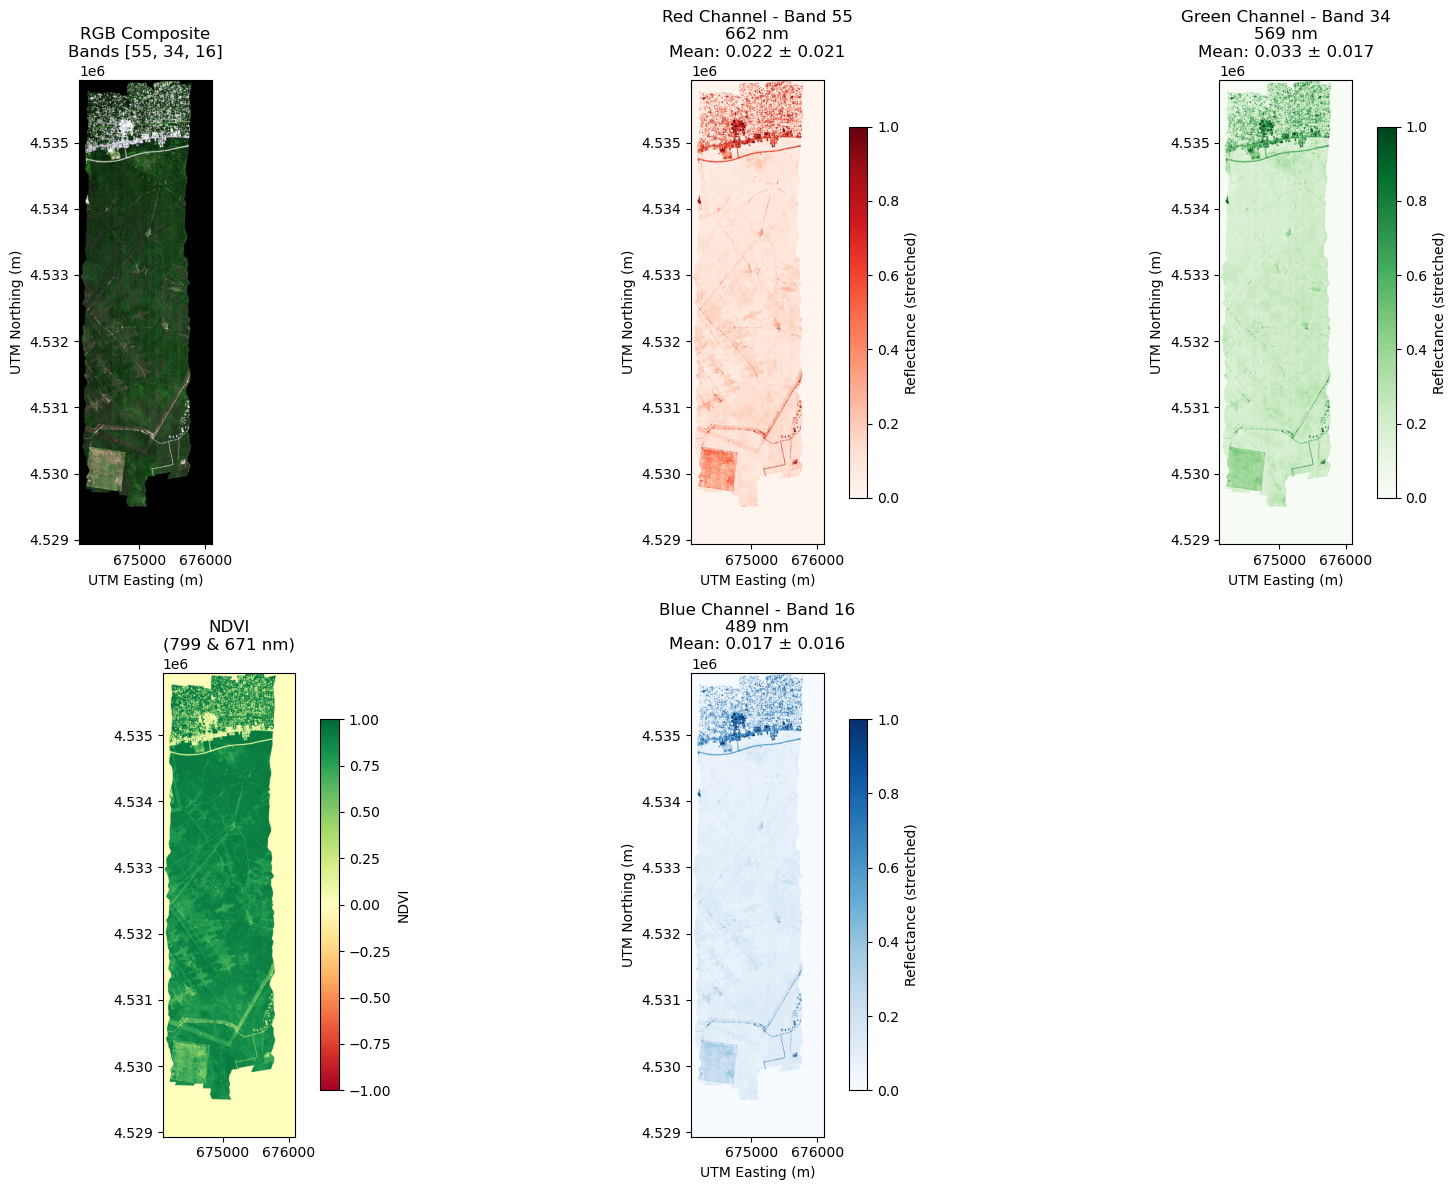

In [102]:
import spectral as spy
import matplotlib.pyplot as plt
import numpy as np

def plot_gliht_with_contrast(hdr_file):
    """Plot with improved contrast for individual bands"""
    
    img = spy.open_image(hdr_file)
    rgb_bands = [55, 34, 16]
    wavelengths = [float(w) for w in img.metadata['wavelength']]
    
    map_info = img.metadata['map info']
    x_origin = float(map_info[3])
    y_origin = float(map_info[4])
    pixel_size = float(map_info[5])
    x_max = x_origin + (img.ncols * pixel_size)
    y_min = y_origin - (img.nrows * pixel_size)
    
    # Create RGB composite 
    rgb_array = np.zeros((img.nrows, img.ncols, 3))
    for i, band_idx in enumerate(rgb_bands):
        band_data = img.read_band(band_idx).astype(float) / 10000.0
        valid_data = band_data[band_data > 0]
        if len(valid_data) > 0:
            p2, p98 = np.percentile(valid_data, [2, 98])
            band_data = np.clip((band_data - p2) / (p98 - p2), 0, 1)
        rgb_array[:, :, i] = band_data
    
    # Create figure
    fig = plt.figure(figsize=(16, 12))
    
    # RGB composite
    ax1 = plt.subplot(2, 3, 1)
    ax1.imshow(rgb_array, extent=[x_origin, x_max, y_min, y_origin])
    ax1.set_title(f'RGB Composite\nBands {rgb_bands}')
    ax1.set_xlabel('UTM Easting (m)')
    ax1.set_ylabel('UTM Northing (m)')
    
    # Individual bands with enhanced contrast
    band_positions = [2, 3, 5]
    band_colors = ['Reds', 'Greens', 'Blues']  # Use color-specific colormaps
    band_names = ['Red', 'Green', 'Blue']
    
    for i, (band_idx, pos, cmap, name) in enumerate(zip(rgb_bands, band_positions, band_colors, band_names)):
        ax = plt.subplot(2, 3, pos)
        
        # Load raw reflectance data
        band_data = img.read_band(band_idx).astype(float)
        
        # Convert to reflectance (0-1 scale)
        reflectance = band_data / 10000.0
        
        # Remove invalid/negative values - need NA/fill filter/mask
        valid_mask = (reflectance > 0) & (reflectance < 1)
        valid_reflectance = reflectance[valid_mask]
        
        if len(valid_reflectance) > 100:  # Need enough valid pixels
            # Use more aggressive stretching for individual bands
            p1, p99 = np.percentile(valid_reflectance, [1, 99])
        
            stretched = np.clip((reflectance - p1) / (p99 - p1), 0, 1)
            
        else:
            stretched = reflectance
        
        im = ax.imshow(stretched, cmap=cmap, extent=[x_origin, x_max, y_min, y_origin])
        
        # Calculate statistics for title
        mean_refl = np.mean(valid_reflectance) if len(valid_reflectance) > 0 else 0
        std_refl = np.std(valid_reflectance) if len(valid_reflectance) > 0 else 0
        
        ax.set_title(f'{name} Channel - Band {band_idx}\n{wavelengths[band_idx]:.0f} nm\nMean: {mean_refl:.3f} ± {std_refl:.3f}')
        ax.set_xlabel('UTM Easting (m)')
        ax.set_ylabel('UTM Northing (m)')
        
        # Colorbar with reflectance values
        cbar = plt.colorbar(im, ax=ax, shrink=0.8)
        cbar.set_label('Reflectance (stretched)')
    
    # NDVI
    ax4 = plt.subplot(2, 3, 4)
    red_idx = np.argmin([abs(w - 670) for w in wavelengths])
    nir_idx = np.argmin([abs(w - 800) for w in wavelengths])
    
    red_band = img.read_band(red_idx).astype(float)
    nir_band = img.read_band(nir_idx).astype(float)
    ndvi = (nir_band - red_band) / (nir_band + red_band + 1e-8)
    
    im4 = ax4.imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1, extent=[x_origin, x_max, y_min, y_origin])
    ax4.set_title(f'NDVI\n({wavelengths[nir_idx]:.0f} & {wavelengths[red_idx]:.0f} nm)')
    plt.colorbar(im4, ax=ax4, shrink=0.8, label='NDVI')
    
    plt.tight_layout()
    plt.show()
    
    return rgb_array

# Usage
hsi_file  = download_dir / 'Rocky_Point_Jun2016_at-sensor_refl_L1G.hdr'
rgb = plot_gliht_with_contrast(hsi_file)

Loading and reprojecting CHM...
Loading and reprojecting DTM...


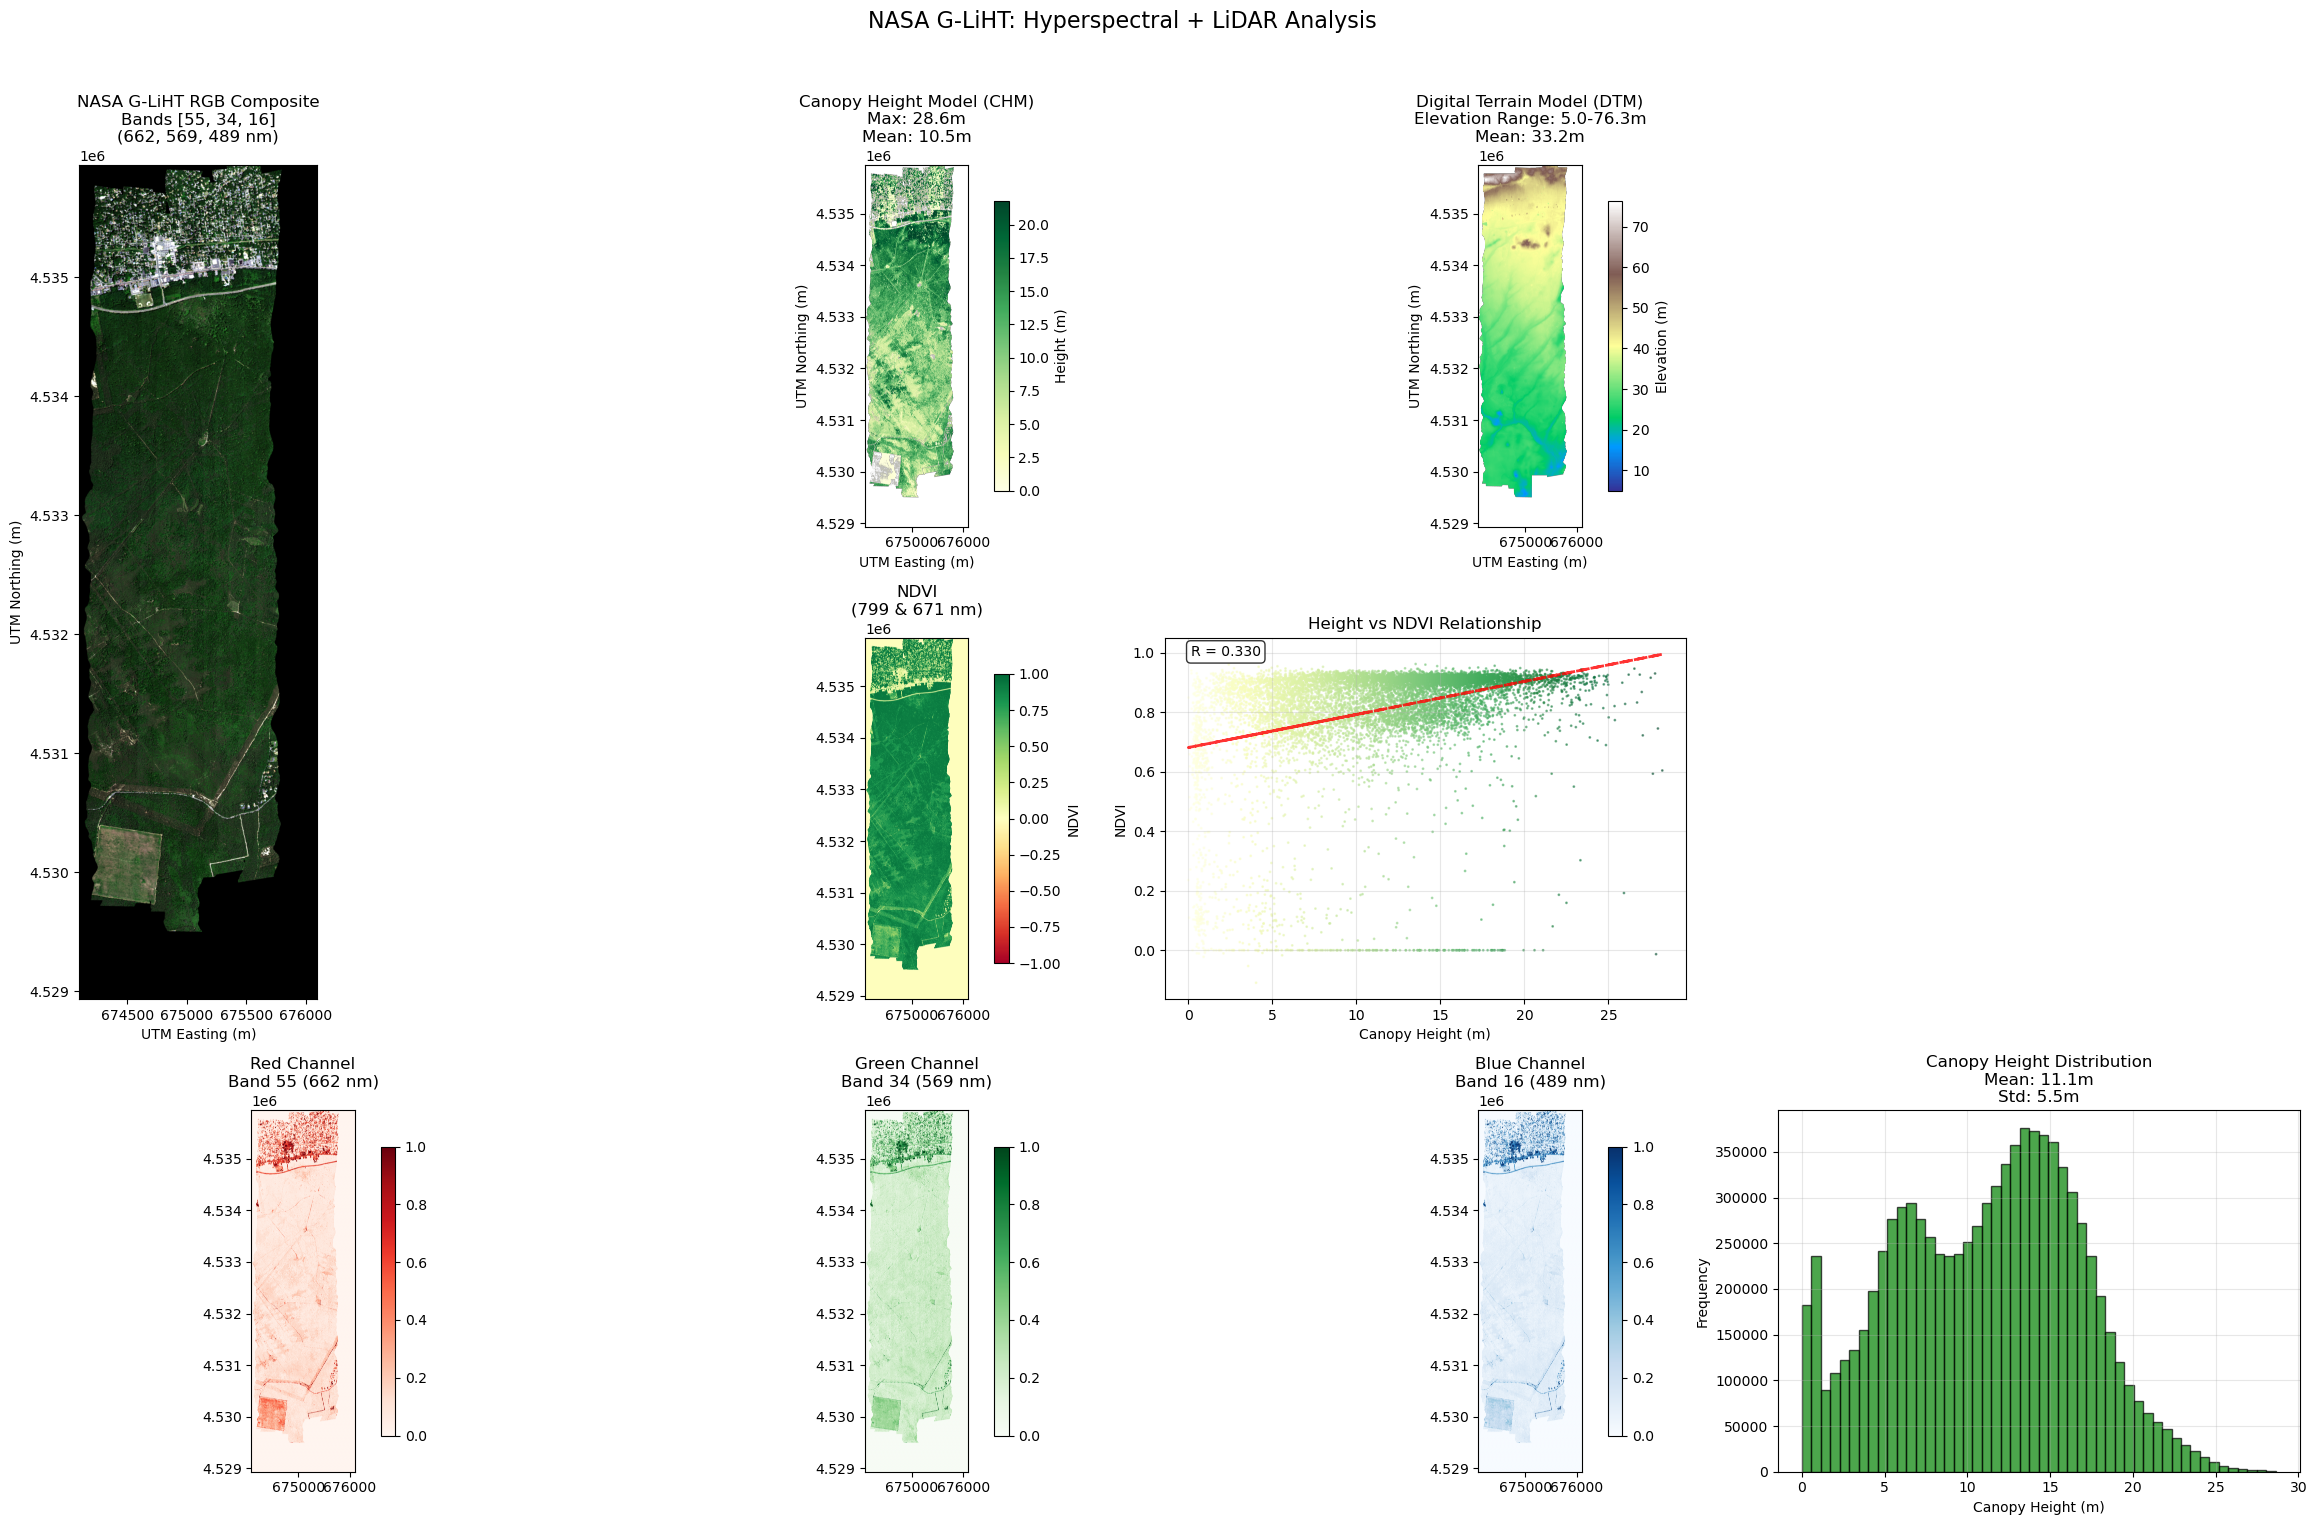

In [106]:
import spectral as spy
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling
from rasterio.transform import from_bounds

def plot_hsi_with_lidar(hdr_file, chm_file, dtm_file):
    """Plot NASA G-LiHT hyperspectral data with CHM and DTM"""
    
    # Load hyperspectral image
    img = spy.open_image(hdr_file)
    rgb_bands = [55, 34, 16]
    wavelengths = [float(w) for w in img.metadata['wavelength']]
    
    # Get hyperspectral geographic info
    map_info = img.metadata['map info']
    x_origin = float(map_info[3])
    y_origin = float(map_info[4])
    pixel_size = float(map_info[5])
    x_max = x_origin + (img.ncols * pixel_size)
    y_min = y_origin - (img.nrows * pixel_size)
    
    # Create RGB composite
    rgb_array = np.zeros((img.nrows, img.ncols, 3))
    for i, band_idx in enumerate(rgb_bands):
        band_data = img.read_band(band_idx).astype(float) / 10000.0
        valid_data = band_data[band_data > 0]
        if len(valid_data) > 0:
            p1, p99 = np.percentile(valid_data, [1, 99])
            band_data = np.clip((band_data - p1) / (p99 - p1), 0, 1)
        rgb_array[:, :, i] = band_data
    
    # Load and reproject CHM and DTM to match hyperspectral extent
    def load_and_reproject_raster(raster_file, target_bounds, target_shape, target_crs='EPSG:32618'):
        """Load and reproject raster to match hyperspectral data"""
        with rasterio.open(raster_file) as src:
            # Define target transform
            target_transform = from_bounds(
                target_bounds[0], target_bounds[2], 
                target_bounds[1], target_bounds[3],
                target_shape[1], target_shape[0]
            )
            
            # Create output array
            output_array = np.zeros(target_shape, dtype=np.float32)
            
            # Reproject
            reproject(
                source=rasterio.band(src, 1),
                destination=output_array,
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=target_transform,
                dst_crs=target_crs,
                resampling=Resampling.bilinear
            )
            
            # Get original statistics for context
            original_data = src.read(1)
            stats = {
                'min': np.nanmin(original_data),
                'max': np.nanmax(original_data),
                'mean': np.nanmean(original_data),
                'std': np.nanstd(original_data)
            }
            
            return output_array, stats
    
    # Load CHM and DTM
    target_bounds = [x_origin, x_max, y_min, y_origin]
    target_shape = (img.nrows, img.ncols)
    
    print("Loading and reprojecting CHM...")
    chm_data, chm_stats = load_and_reproject_raster(chm_file, target_bounds, target_shape)
    
    print("Loading and reprojecting DTM...")
    dtm_data, dtm_stats = load_and_reproject_raster(dtm_file, target_bounds, target_shape)
    
    # Create figure with expanded layout
    fig = plt.figure(figsize=(24, 16))
    
    # Main RGB composite (large)
    ax1 = plt.subplot(3, 4, (1, 5))
    ax1.imshow(rgb_array, extent=[x_origin, x_max, y_min, y_origin])
    ax1.set_title(f'NASA G-LiHT RGB Composite\nBands {rgb_bands}\n({wavelengths[55]:.0f}, {wavelengths[34]:.0f}, {wavelengths[16]:.0f} nm)')
    ax1.set_xlabel('UTM Easting (m)')
    ax1.set_ylabel('UTM Northing (m)')
    
    # CHM (Canopy Height Model)
    ax2 = plt.subplot(3, 4, 2)
    chm_masked = np.ma.masked_where(chm_data <= 0, chm_data)  # Mask ground/negative values
    im2 = ax2.imshow(chm_masked, cmap='YlGn', extent=[x_origin, x_max, y_min, y_origin],
                     vmin=0, vmax=np.percentile(chm_data[chm_data > 0], 98))
    ax2.set_title(f'Canopy Height Model (CHM)\nMax: {chm_stats["max"]:.1f}m\nMean: {chm_stats["mean"]:.1f}m')
    ax2.set_xlabel('UTM Easting (m)')
    ax2.set_ylabel('UTM Northing (m)')
    cbar2 = plt.colorbar(im2, ax=ax2, shrink=0.8)
    cbar2.set_label('Height (m)')
    
    # DTM (Digital Terrain Model)
    ax3 = plt.subplot(3, 4, 3)
    im3 = ax3.imshow(dtm_data, cmap='terrain', extent=[x_origin, x_max, y_min, y_origin])
    ax3.set_title(f'Digital Terrain Model (DTM)\nElevation Range: {dtm_stats["min"]:.1f}-{dtm_stats["max"]:.1f}m\nMean: {dtm_stats["mean"]:.1f}m')
    ax3.set_xlabel('UTM Easting (m)')
    ax3.set_ylabel('UTM Northing (m)')
    cbar3 = plt.colorbar(im3, ax=ax3, shrink=0.8)
    cbar3.set_label('Elevation (m)')
    
    # Vegetation height analysis (CHM with RGB overlay) needs cleaning
    # ax4 = plt.subplot(3, 4, 4)
    # ax4.imshow(rgb_array, extent=[x_origin, x_max, y_min, y_origin], alpha=0.7)
    
    # Overlay CHM contours
    # height_levels = np.arange(0, np.max(chm_data), 5)  # 5m contour intervals
    # cs = ax4.contour(chm_masked, levels=height_levels, colors='white', alpha=0.8, linewidths=0.5,
    #                  extent=[x_origin, x_max, y_min, y_origin])
    # ax4.clabel(cs, inline=True, fontsize=8, fmt='%dm')
    # ax4.set_title('RGB with Height Contours\n(5m intervals)')
    # ax4.set_xlabel('UTM Easting (m)')
    # ax4.set_ylabel('UTM Northing (m)')
    
    # NDVI
    ax5 = plt.subplot(3, 4, 6)
    red_idx = np.argmin([abs(w - 670) for w in wavelengths])
    nir_idx = np.argmin([abs(w - 800) for w in wavelengths])
    
    red_band = img.read_band(red_idx).astype(float)
    nir_band = img.read_band(nir_idx).astype(float)
    ndvi = (nir_band - red_band) / (nir_band + red_band + 1e-8)
    
    im5 = ax5.imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1, extent=[x_origin, x_max, y_min, y_origin])
    ax5.set_title(f'NDVI\n({wavelengths[nir_idx]:.0f} & {wavelengths[red_idx]:.0f} nm)')
    plt.colorbar(im5, ax=ax5, shrink=0.8, label='NDVI')
    
    # Height vs NDVI scatter plot
    ax6 = plt.subplot(3, 4, 7)
    
    # Sample data for scatter plot (subsample for performance)
    valid_mask = (chm_data > 0) & (~np.isnan(ndvi)) & (ndvi > -1) & (ndvi < 1)
    sample_indices = np.where(valid_mask)
    
    if len(sample_indices[0]) > 10000:  # Subsample if too many points
        sample_idx = np.random.choice(len(sample_indices[0]), 10000, replace=False)
        sample_chm = chm_data[sample_indices[0][sample_idx], sample_indices[1][sample_idx]]
        sample_ndvi = ndvi[sample_indices[0][sample_idx], sample_indices[1][sample_idx]]
    else:
        sample_chm = chm_data[valid_mask]
        sample_ndvi = ndvi[valid_mask]
    
    ax6.scatter(sample_chm, sample_ndvi, alpha=0.5, s=1, c=sample_chm, cmap='YlGn')
    ax6.set_xlabel('Canopy Height (m)')
    ax6.set_ylabel('NDVI')
    ax6.set_title('Height vs NDVI Relationship')
    ax6.grid(True, alpha=0.3)
    
    # Add trend line
    if len(sample_chm) > 100:
        z = np.polyfit(sample_chm, sample_ndvi, 1)
        p = np.poly1d(z)
        ax6.plot(sample_chm, p(sample_chm), "r--", alpha=0.8, linewidth=2)
        correlation = np.corrcoef(sample_chm, sample_ndvi)[0, 1]
        ax6.text(0.05, 0.95, f'R = {correlation:.3f}', transform=ax6.transAxes, 
                bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))
    
    # Individual RGB bands (enhanced contrast)
    band_positions = [9, 10, 11]
    band_colors = ['Reds', 'Greens', 'Blues']
    band_names = ['Red', 'Green', 'Blue']
    
    for i, (band_idx, pos, cmap, name) in enumerate(zip(rgb_bands, band_positions, band_colors, band_names)):
        ax = plt.subplot(3, 4, pos)
        band_data = img.read_band(band_idx).astype(float) / 10000.0
        valid_data = band_data[(band_data > 0) & (band_data < 1)]
        if len(valid_data) > 0:
            p1, p99 = np.percentile(valid_data, [1, 99])
            band_enhanced = np.clip((band_data - p1) / (p99 - p1), 0, 1)
        else:
            band_enhanced = band_data
            
        im = ax.imshow(band_enhanced, cmap=cmap, extent=[x_origin, x_max, y_min, y_origin])
        ax.set_title(f'{name} Channel\nBand {band_idx} ({wavelengths[band_idx]:.0f} nm)')
        plt.colorbar(im, ax=ax, shrink=0.8)
    
    # Height histogram
    ax12 = plt.subplot(3, 4, 12)
    chm_valid = chm_data[chm_data > 0]
    ax12.hist(chm_valid, bins=50, alpha=0.7, color='green', edgecolor='black')
    ax12.set_xlabel('Canopy Height (m)')
    ax12.set_ylabel('Frequency')
    ax12.set_title(f'Canopy Height Distribution\nMean: {np.mean(chm_valid):.1f}m\nStd: {np.std(chm_valid):.1f}m')
    ax12.grid(True, alpha=0.3)
    
    plt.suptitle('NASA G-LiHT: Hyperspectral + LiDAR Analysis', fontsize=16, y=0.98)
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()
    
    return rgb_array, chm_data, dtm_data, ndvi

# Usage
rgb, chm, dtm, ndvi = plot_hsi_with_lidar(hsi_file, chm_file, dtm_file)

## Analyses
Organize your notebook using headers to delineate meaningful sections.

In [ ]:
# extending the data to insights on the environment, modeling, etc

## Save or Export results

In [ ]:
# save any outputs you may generate, close all datasets if not already